In [54]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar xvzf ldcc-20140209.tar.gz

Streaming output truncated to the last 5000 lines.
text/smax/smax-6833065.txt
text/smax/smax-6833494.txt
text/smax/smax-6833579.txt
text/smax/smax-6834422.txt
text/smax/smax-6834562.txt
text/smax/smax-6834765.txt
text/smax/smax-6834990.txt
text/smax/smax-6835318.txt
text/smax/smax-6838218.txt
text/smax/smax-6838260.txt
text/smax/smax-6838332.txt
text/smax/smax-6838453.txt
text/smax/smax-6838514.txt
text/smax/smax-6838627.txt
text/smax/smax-6838702.txt
text/smax/smax-6842164.txt
text/smax/smax-6842219.txt
text/smax/smax-6842269.txt
text/smax/smax-6842402.txt
text/smax/smax-6842629.txt
text/smax/smax-6842882.txt
text/smax/smax-6843206.txt
text/smax/smax-6845003.txt
text/smax/smax-6847081.txt
text/smax/smax-6849018.txt
text/smax/smax-6850114.txt
text/smax/smax-6850391.txt
text/smax/smax-6850789.txt
text/smax/smax-6851590.txt
text/smax/smax-6851919.txt
text/smax/smax-6853063.txt
text/smax/smax-6853346.txt
text/smax/smax-6853751.txt
text/smax/smax-6854198.txt
text/smax/smax-6855347.txt
text

In [55]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.5
#pip install mecab-python3
!pip install pyyaml==5.4.1
!pip install unidic-lite nlplot japanize-matplotlib transformers fugashi ipadic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.12)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.19)
xz-utils is already installed at the requested version (5.2.2-1.3ubuntu0.1)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is alre

In [56]:
#データセットの読み込み
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import nlplot
import warnings
warnings.simplefilter('ignore')    
import torch
import transformers
from transformers import BertJapaneseTokenizer
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR) # tokenize時の警告を抑制
def load_dataset():
    """データセットの読み込み"""
    paths = []
    for dirpath, dirnames, filenames in os.walk('./text'):
        for file in filenames:
            if re.match(r'.+[0-9].txt',  file):
                #print("{0}".format(file))
                paths.append(os.path.join(dirpath, file))                
    data = {
        'path': [],
        'URL': [],
        'date': [],
        'title': [],
        'text': [],
    }
    for path in paths:
        with open(path, 'r') as f:
            url = f.readline().strip('¥n')
            date = f.readline().strip('¥n')
            title = f.readline().strip('¥n')
            text = f.read()
            data['path'].append(path)
            data['URL'].append(url)
            data['date'].append(date)
            data['title'].append(title)
            data['text'].append(text)
    return pd.DataFrame(data)
#データセットのパス、記事のURL、日付、記事のタイトル、本文を格納した DataFrame を返す
df = load_dataset()

In [59]:
class BertExtractor:
    """文書特徴抽出用クラス"""
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPUが使用可能ならGPUを使用
        self.model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking' #使用する学習済みモデル名
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(self.model_name) #使用するBERTトークナイザー
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name) #学習済みモデル呼び出し
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128 #使用する入力文書の長さ。最大512まで
    def extract(self, sentence):
        """文書特徴ベクトルを抽出する"""
        # 文書のトークナイズ
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)
        # 入力トークン数の調整
        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
        else:
            inputs = inp + [0] * (self.max_len - len_inp) #padding
        # モデルへ文書を入力し特徴ベクトルを取り出す
        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)        
        seq_out = self.bert_model(inputs_tensor)[0]
        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [60]:
def cos_sim_matrix(matrix):
    """文書間のコサイン類似度を計算し、類似度行列を返す"""
    d = matrix @ matrix.T 
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T
bex = BertExtractor()
df['text_feature'] = df['text'].progress_apply(lambda x: bex.extract(x)) # 文書の特徴ベクトル化
sim=cos_sim_matrix(np.stack(df.text_feature)) # 類似度行列

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/7367 [00:00<?, ?it/s]

In [70]:
#類似文書の検索
#ランダムに記事を一つ選び、その記事と類似度が高い記事を100件取り出す
def search(n=100):
    doc = df.sample(1)
    doc_idx = doc.index[0]
    sim_index = sim[doc_idx].argsort()[::-1]
    rec_df = df.iloc[sim_index][:n]
    rec_df['similarity'] = np.sort(sim[doc_idx])[::-1][:n]
    return rec_df[['title', 'text', 'similarity']]
df2 = search()


In [71]:
df2.head(10)

,title,text,similarity
2002,映画界の“生きる伝説”が人類の起源に迫る\n,決して触れてはならない“謎”に巨匠が挑む！ 『エイリアン』『グラディエーター』など映画史上...,1.000000
2274,人類を創ったのは“神”でも“進化論”でも“DNA”でもない\n,『エイリアン』『グラディエーター』など映画史上において幾多の金字塔を打ち建ててきた、生きる...,0.941475
1913,【終了しました】剛力彩芽に会える！ 映画『プロメテウス』のスペシャルイベントにご招待\n,『エイリアン』『グラディエーター』など、映画史上において幾多の金字塔を打ち立ててきた“生き...,0.935147
2184,リドリー・スコット監督最新作で謎だらけのキャンペーンを開始\n,空前絶後の衝撃を呼ぶ3Dエピック・ミステリー巨編が日本上陸！ 『エイリアン』『グラディエー...,0.931118
2131,人類誕生の謎が明かされる！ 宇宙に飛び出した科学者が見たものとは\n,『エイリアン』『グラディエーター』など映画史上において幾多の金字塔を打ち建ててきた、生きる...,0.926019
2059,『ミッション：8ミニッツ』繰り返される“8分間”の悪夢に隠された真実とは\n,全米でこの春公開され、観る者の想像を完璧なまでに裏切る鮮やかなプロットで映画ファンを騒然と...,0.925816
2129,伝説が、壮絶に、終わる！『ダークナイト ライジング』最後の予告編が解禁に\n,公開時に全米歴代2位というメガヒットを記録、ハリウッド映画の過去のセオリーを叩きつぶし、その...,0.922079
2090,日本のインディ・ジョーンズが解明！『ダ・ヴィンチ・コード』を超える今世紀最大の発見とは？\n,映画や小説の世界には、定説を覆す驚くほどのセンセーショナルな作品が存在する。ダン・ブラン原...,0.913672
2156,使われなくなった地下鉄ホームに巨大人面像が出現\n,生きる伝説リドリー・スコット監督が満を持して放つ、「人類の起源」という壮大な謎に迫る今夏最...,0.913214
2302,神を自負した男が、無限の野心の果てに追い求めたもの\n,8月4日からの先行上映を経て、いよいよ24日に全国公開となったリドリー・スコット監督最新作...,0.912988


In [72]:
#検索結果の可視化
def tokenize(text,):
    tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    wakati_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist())
    return tokens[1:-1] #[CLS], [SEP]トークンを除く
df2['tokenized_text'] = df2['text'].progress_apply(tokenize)

npt = nlplot.NLPlot(df2, target_col='tokenized_text')
# top_nで頻出上位単語, min_freqで頻出下位単語を指定できる
stopwords = npt.get_stopword(top_n=20, min_freq=0)
# bi-gram表示
npt.bar_ngram(
    title='bi-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=2,
    top_n=50,
    stopwords=stopwords,
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1919.63it/s]


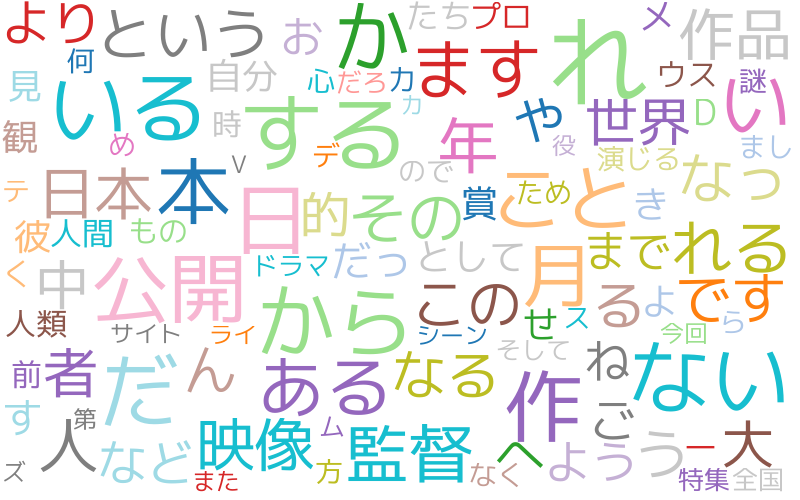

In [73]:
#wordcloud表示
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)